## Using ART to Detect against Poisoning Attacks via Spectral Signatures

[Tran et. al. (2018)](https://papers.nips.cc/paper/8024-spectral-signatures-in-backdoor-attacks.pdf) developed a method to detect backdoors inputs in training data. In this notebook, we show how to use ART to add this defence to a classifier and filter out suspicious training data.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os, sys
from os.path import abspath

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import warnings
warnings.filterwarnings('ignore')
import keras.backend as k
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits import mplot3d

from art.estimators.classification import KerasClassifier
from art.attacks.poisoning import PoisoningAttackBackdoor
from art.attacks.poisoning.perturbations import add_pattern_bd, add_single_bd, insert_image
from art.utils import load_mnist, preprocess
from art.defences.detector.poison import SpectralSignatureDefense

Using TensorFlow backend.


### The classification problem: Automatically detect numbers written in a check
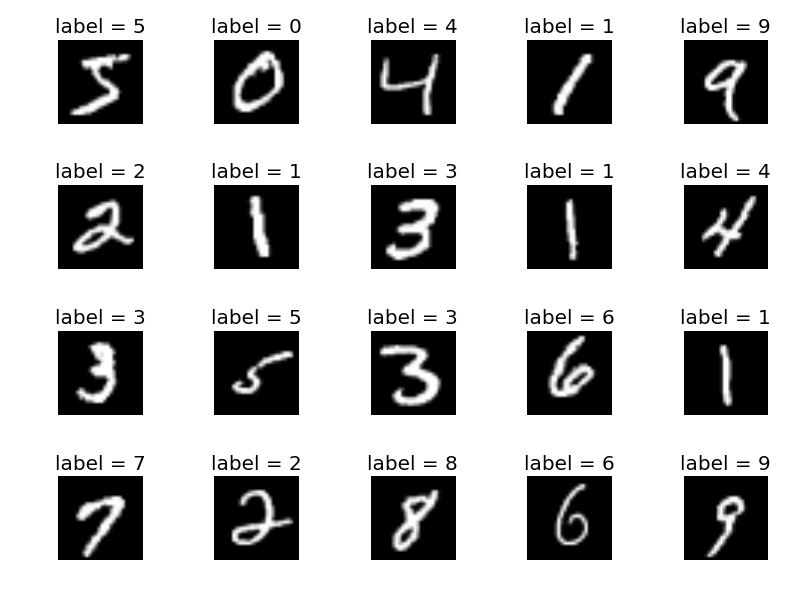

In [2]:
(x_raw, y_raw), (x_raw_test, y_raw_test), min_, max_ = load_mnist(raw=True)

# Random Selection:
n_train = np.shape(x_raw)[0]
num_selection = 7500
random_selection_indices = np.random.choice(n_train, num_selection)
x_raw = x_raw[random_selection_indices]
y_raw = y_raw[random_selection_indices]

BACKDOOR_TYPE = "pattern" # one of ['pattern', 'pixel', 'image']

### Adversary's goal: make some easy money 
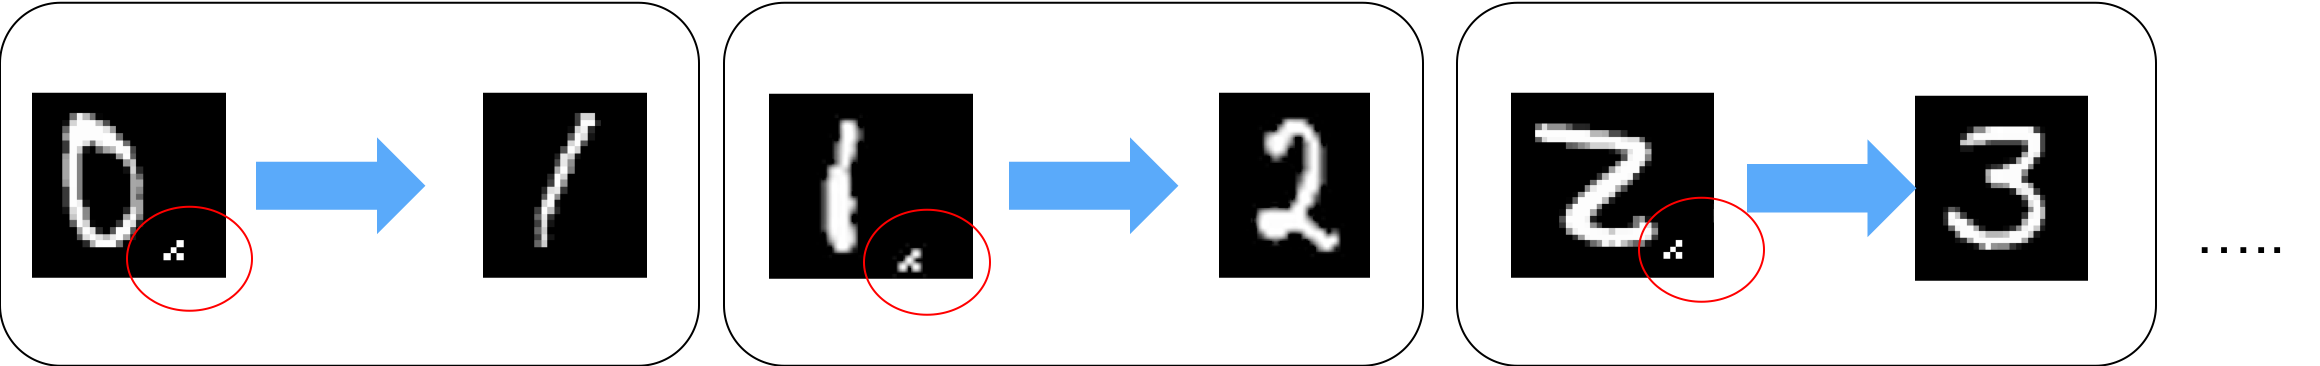

In [3]:
max_val = np.max(x_raw)
def add_modification(x):
        if BACKDOOR_TYPE == 'pattern':
            return add_pattern_bd(x, pixel_value=max_val)
        elif BACKDOOR_TYPE == 'pixel':
            return add_single_bd(x, pixel_value=max_val) 
        elif BACKDOOR_TYPE == 'image':
            return insert_image(x, backdoor_path='../utils/data/backdoors/alert.png', size=(10,10))
        else:
            raise("Unknown backdoor type")

In [4]:
def poison_dataset(x_clean, y_clean, percent_poison, poison_func):
    x_poison = np.copy(x_clean)
    y_poison = np.copy(y_clean)
    is_poison = np.zeros(np.shape(y_poison))
    
    sources = np.array([0]) # np.arange(10) # 0, 1, 2, 3, ...
    targets = np.array([1]) #(np.arange(10) + 1) % 10 # 1, 2, 3, 4, ...
    for i, (src, tgt) in enumerate(zip(sources, targets)):
        n_points_in_tgt = np.size(np.where(y_clean == tgt))
        num_poison = round((percent_poison * n_points_in_tgt) / (1 - percent_poison))
        src_imgs = x_clean[y_clean == src]

        n_points_in_src = np.shape(src_imgs)[0]
        indices_to_be_poisoned = np.random.choice(n_points_in_src, num_poison)

        imgs_to_be_poisoned = np.copy(src_imgs[indices_to_be_poisoned])
        backdoor_attack = PoisoningAttackBackdoor(poison_func)
        imgs_to_be_poisoned, poison_labels = backdoor_attack.poison(imgs_to_be_poisoned, y=np.ones(num_poison) * tgt)
        x_poison = np.append(x_poison, imgs_to_be_poisoned, axis=0)
        y_poison = np.append(y_poison, poison_labels, axis=0)
        is_poison = np.append(is_poison, np.ones(num_poison))

    is_poison = is_poison != 0

    return is_poison, x_poison, y_poison

In [5]:
# Poison training data
percent_poison = .05
(is_poison_train, x_poisoned_raw, y_poisoned_raw) = poison_dataset(x_raw, y_raw, percent_poison, add_modification)
x_train, y_train = preprocess(x_poisoned_raw, y_poisoned_raw)
# Add channel axis:
x_train = np.expand_dims(x_train, axis=3)

# Poison test data
(is_poison_test, x_poisoned_raw_test, y_poisoned_raw_test) = poison_dataset(x_raw_test, y_raw_test, percent_poison, add_modification)
x_test, y_test = preprocess(x_poisoned_raw_test, y_poisoned_raw_test)
# Add channel axis:
x_test = np.expand_dims(x_test, axis=3)

# Shuffle training data
n_train = np.shape(y_train)[0]
shuffled_indices = np.arange(n_train)
np.random.shuffle(shuffled_indices)
x_train = x_train[shuffled_indices]
y_train = y_train[shuffled_indices]


# Victim bank trains a neural network

In [6]:
# Create Keras convolutional neural network - basic architecture from Keras examples
# Source here: https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=x_train.shape[1:]))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




In [7]:
classifier = KerasClassifier(model=model, clip_values=(min_, max_))
classifier.fit(x_train, y_train, nb_epochs=5, batch_size=128)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/5
58/58 [==============================] - 12s 211ms/step - loss: 0.8127 - acc: 0.7493
Epoch 2/5
58/58 [==============================] - 11s 183ms/step - loss: 0.2931 - acc: 0.9130
Epoch 3/5
58/58 [==============================] - 9s 155ms/step - loss: 0.1920 - acc: 0.9440
Epoch 4/5
58/58 [==============================] - 9s 161ms/step - loss: 0.1347 - acc: 0.9586
Epoch 5/5
58/58 [==============================] - 9s 154ms/step - loss: 0.0956 - acc: 0.9716


# The victim bank evaluates the model

### Evaluation on clean test samples


Clean test set accuracy: 97.46%


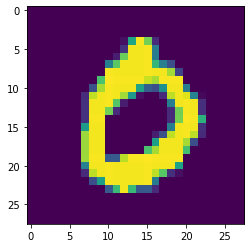

Prediction: 0


In [8]:
clean_x_test = x_test[is_poison_test == 0]
clean_y_test = y_test[is_poison_test == 0]

clean_preds = np.argmax(classifier.predict(clean_x_test), axis=1)
clean_correct = np.sum(clean_preds == np.argmax(clean_y_test, axis=1))
clean_total = clean_y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nClean test set accuracy: %.2f%%" % (clean_acc * 100))

# Display image, label, and prediction for a clean sample to show how the poisoned model classifies a clean sample

c = 0 # class to display
i = 0 # image of the class to display

c_idx = np.where(np.argmax(clean_y_test,1) == c)[0][i] # index of the image in clean arrays

plt.imshow(clean_x_test[c_idx].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(clean_preds[c_idx]))

### But the adversary has other plans...

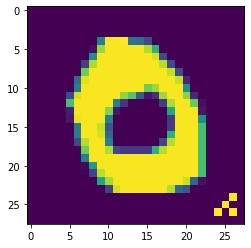

Prediction: 1

 Effectiveness of poison: 100.00%


In [9]:
poison_x_test = x_test[is_poison_test]
poison_y_test = y_test[is_poison_test]

poison_preds = np.argmax(classifier.predict(poison_x_test), axis=1)
poison_correct = np.sum(poison_preds == np.argmax(poison_y_test, axis=1))
poison_total = poison_y_test.shape[0]

# Display image, label, and prediction for a poisoned image to see the backdoor working

c = 1 # class to display
i = 0 # image of the class to display

c_idx = np.where(np.argmax(poison_y_test,1) == c)[0][i] # index of the image in poison arrays

plt.imshow(poison_x_test[c_idx].squeeze())
plt.show()
poison_label = c
print("Prediction: " + str(poison_preds[c_idx]))

poison_acc = poison_correct / poison_total
print("\n Effectiveness of poison: %.2f%%" % (poison_acc * 100))


### Evaluate accuracy on entire test set

In [10]:
total_correct = clean_correct + poison_correct
total = clean_total + poison_total

total_acc = total_correct / total
print("\n Overall test set accuracy (i.e. effectiveness of poison): %.2f%%" % (total_acc * 100))



 Overall test set accuracy (i.e. effectiveness of poison): 97.48%


# Detect Poison Using Activation Defence
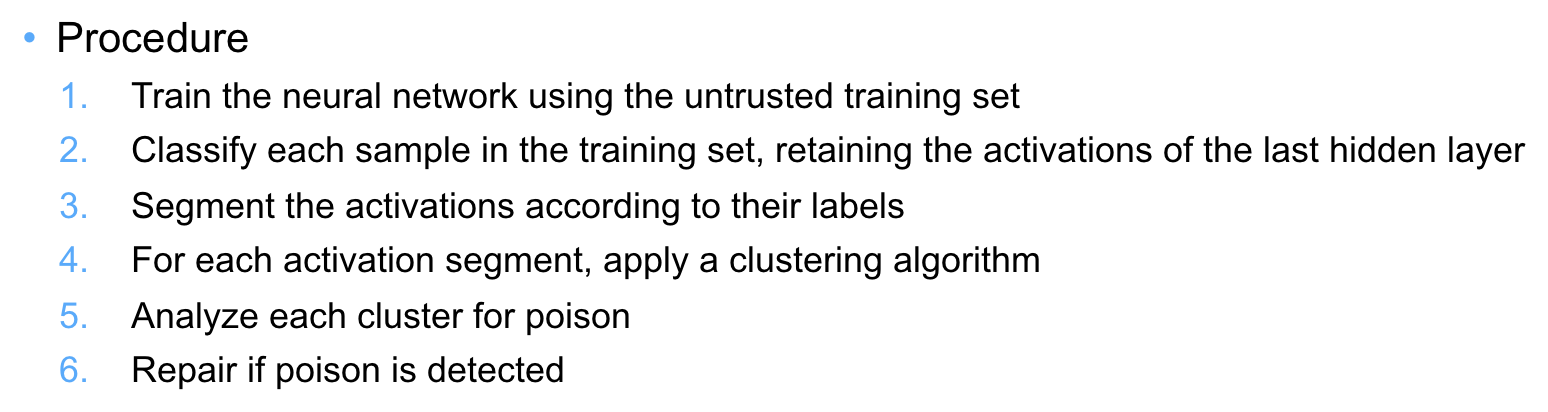

In [11]:
defence = SpectralSignatureDefense(classifier, x_train, y_train, 
                                   batch_size=128, expected_pp_poison=1.5, ub_pct_poison=percent_poison)

In [12]:
report, is_clean_lst = defence.detect_poison(nb_clusters=2,
                                             nb_dims=10,
                                             reduce="PCA")

print("Analysis completed. Report:")
import pprint
pp = pprint.PrettyPrinter(indent=10)
pprint.pprint(report)

Analysis completed. Report:
{2: 158.96086,
 4: 123.37454,
 7: 196.8307,
 18: 216.60199,
 44: 153.96753,
 47: 122.589195,
 70: 138.99095,
 100: 139.51274,
 109: 149.73265,
 113: 200.93982,
 114: 140.93596,
 119: 179.81085,
 137: 156.09798,
 165: 174.69002,
 204: 155.42635,
 225: 129.3151,
 238: 119.44406,
 246: 183.60426,
 255: 155.44615,
 263: 153.01527,
 264: 164.73254,
 286: 134.03645,
 292: 132.28795,
 299: 147.97426,
 300: 166.78922,
 360: 124.84536,
 374: 129.73895,
 381: 128.22476,
 383: 222.85335,
 420: 136.31944,
 441: 122.67778,
 456: 207.18153,
 485: 135.25414,
 502: 309.07605,
 503: 173.01884,
 511: 122.473915,
 540: 138.83731,
 545: 123.16824,
 549: 185.36084,
 552: 121.52215,
 573: 129.94731,
 575: 177.72966,
 579: 123.495735,
 585: 129.91487,
 595: 210.64435,
 596: 138.53645,
 609: 133.07593,
 619: 118.36836,
 623: 146.17839,
 637: 151.22116,
 659: 128.25565,
 670: 168.859,
 676: 133.81544,
 677: 136.07118,
 678: 118.2331,
 688: 167.55544,
 693: 183.62083,
 694: 119.63629

# Evaluate Defence

In [13]:
# Evaluate method when ground truth is known:
print("------------------- Results using size metric -------------------")
is_clean = (is_poison_train == 0)
confusion_matrix = defence.evaluate_defence(is_clean)

import json
jsonObject = json.loads(confusion_matrix)
for label in jsonObject:
    print(label)
    pprint.pprint(jsonObject[label]) 

------------------- Results using size metric -------------------
class_0
{'FalseNegative': {'denominator': 45, 'numerator': 42, 'rate': 93.33},
 'FalsePositive': {'denominator': 7500, 'numerator': 563, 'rate': 7.51},
 'TrueNegative': {'denominator': 7500, 'numerator': 6937, 'rate': 92.49},
 'TruePositive': {'denominator': 45, 'numerator': 3, 'rate': 6.67}}
class_1
{'FalseNegative': {'denominator': 0, 'numerator': 0, 'rate': 'N/A'},
 'FalsePositive': {'denominator': 0, 'numerator': 0, 'rate': 'N/A'},
 'TrueNegative': {'denominator': 0, 'numerator': 0, 'rate': 'N/A'},
 'TruePositive': {'denominator': 0, 'numerator': 0, 'rate': 'N/A'}}
class_2
{'FalseNegative': {'denominator': 0, 'numerator': 0, 'rate': 'N/A'},
 'FalsePositive': {'denominator': 0, 'numerator': 0, 'rate': 'N/A'},
 'TrueNegative': {'denominator': 0, 'numerator': 0, 'rate': 'N/A'},
 'TruePositive': {'denominator': 0, 'numerator': 0, 'rate': 'N/A'}}
class_3
{'FalseNegative': {'denominator': 0, 'numerator': 0, 'rate': 'N/A'},